# Introduction to Prophet

Traditional time series models use past values to predict future values. Prophet, however, decomposes a time series into smooth functions that sum to reconstruct the observed data:

$$
y_t = g(t) + s(t) + h(t) + \epsilon_t
$$

Where g(t) is trend component, s(t) is seasonal component and h(t) are impact effects of holiday, events or external regressor.

Prophet does not require stationarity since it models trends explicitly. Therefore, it learns the trend rather than removing it unlike ARIMA. Due to its heavy reliance on trend estimation, error in trend modelling can significantly affect performance.

Unlike standard GAMs, Prophet estimates parameters using Bayesian inference via Markov Chain Monte Carlo (MCMC):

$$
P(\theta \mid D) \propto P(D \mid \theta) P(\theta)
$$

where $P(\theta \mid D)$ is the **posterior** , $P(D \mid \theta)$ is the **likelihood** and $P(\theta)$ is the **prior** distribution.


## Loss Functions

In [ ]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse


def peak_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_load_true = np.max(y_true)
    plape = np.abs((peak_load_true - np.max(y_pred)) / peak_load_true) * 100
    return plape


def value_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_min_true = np.min(y_true)
    vlape = np.abs((peak_min_true - np.min(y_pred)) / peak_min_true) * 100
    return vlape


def energy_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total_energy_true = np.sum(y_true)
    total_energy_pred = np.sum(y_pred)
    eape = np.abs((total_energy_true - total_energy_pred) / total_energy_true) * 100

    return eape

# Imports

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualizing the entire dataset decomposition

From the decomposition, we see that whenever the trend increases, the seasonality increases. As such, we will set seasonality_mode ="multiplicative". However, the increase in accuracy is minimal for the simple prophet model as we can see below in the experiment. However, when you set seasonality_mode to multiplicative, the effect of holiday effect is also strengthed. Therefore in the 2nd experiment of incorporating the effect of holidays, we once again use this configuration and see if there is any accuracy.




DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/ixuo69jo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/xjoccqt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37692', 'data', 'file=/tmp/tmpb5ozbe0o/ixuo69jo.json', 'init=/tmp/tmpb5ozbe0o/xjoccqt9.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_modelm916qtnf/prophet_model-20250228182840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


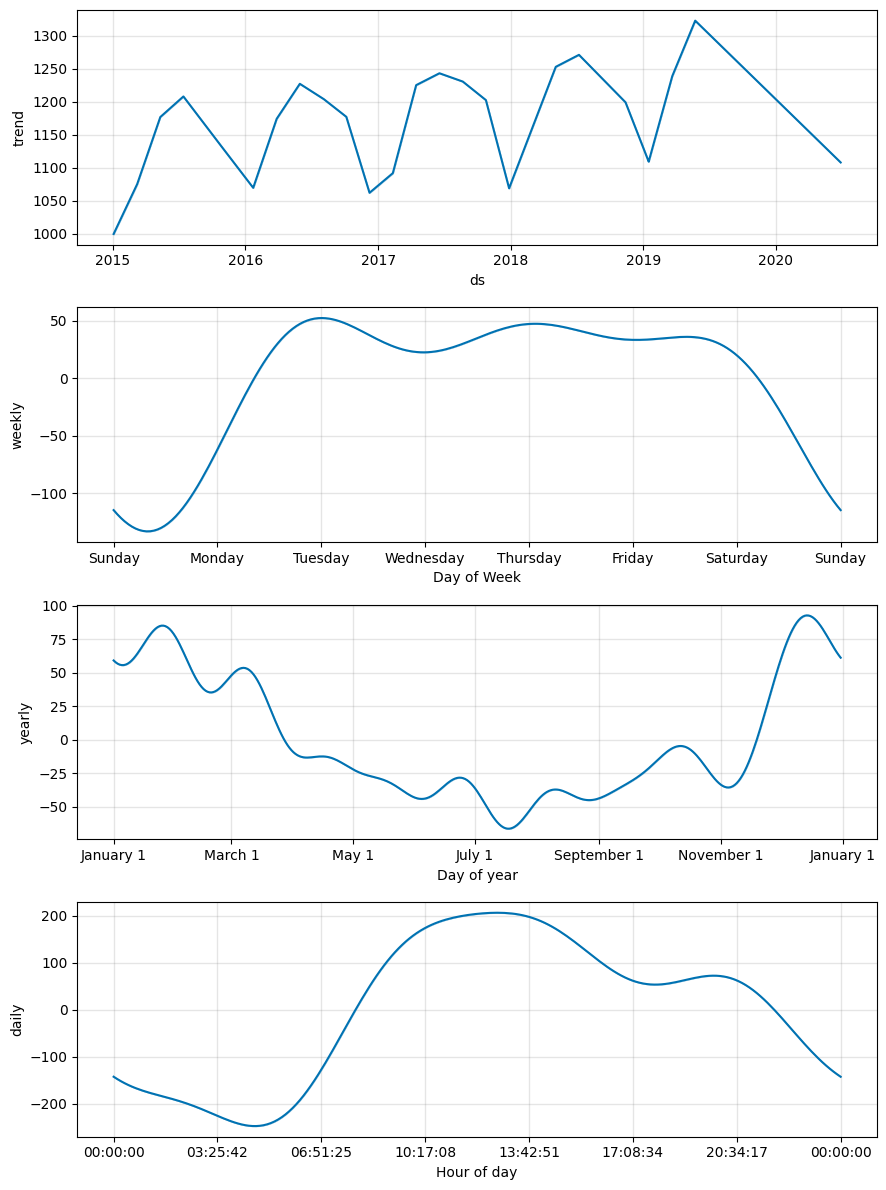

In [ ]:
file_path = "/content/drive/My Drive/Datasets/Panama_Dataset/continuous dataset.csv"
df = pd.read_csv(file_path)
df = df.set_index("datetime")
df_viz = df["nat_demand"]


df_viz = df_viz.reset_index().rename(columns = {"datetime":"ds",
                                           "nat_demand":"y"})

model = Prophet()
model.fit(df_viz)
fig = model.plot_components(model.predict(df_viz))
plt.show()

# Implementing Prophet

In [ ]:
train_path = "/content/drive/My Drive/Datasets/Panama_Dataset/train_dataframes.xlsx"
test_path = "/content/drive/My Drive/Datasets/Panama_Dataset/test_dataframes.xlsx"
train_dict = pd.read_excel(open(train_path, 'rb'), sheet_name = None, index_col=0)
# Import a dictionary with all the testing dataframes
test_dict = pd.read_excel(open(test_path, 'rb'), sheet_name = None, index_col=0)
keys = list(train_dict.keys())

In [ ]:
train = train_dict[keys[0]]
test = test_dict[keys[0]]

#print(train.head(5))
#print(len(train)) # We should obtain 36721
#print(len(test)) # We should obtain 168

# Simple Prophet Model

Initially we are going to implement Prophet Model without incorporating any of the features given in the dataset and evaluate the performance of the model.

1. Prophet Model expects the dataset to be named in a specific way:

- Datetime column named: ds
- target : y


In [ ]:
#transforming our data so it only contains the target feature and datetime:
train = train[ "DEMAND"]
test = test[ "DEMAND"]

train.head()

#now performing a transformation to rename the columns:

train_prophet = train.reset_index().rename(columns = {"datetime":"ds",
                                           "DEMAND":"y"})

test_prophet = test.reset_index().rename(columns = {"datetime":"ds",
                                           "DEMAND":"y"})

train_prophet.head()

,ds,y
0,2015-01-31 01:00:00,954.2018
1,2015-01-31 02:00:00,913.8660
2,2015-01-31 03:00:00,903.3637
3,2015-01-31 04:00:00,889.0806
4,2015-01-31 05:00:00,910.1472


In [ ]:

# Training the model is easy. We invoke the Prophet () object from the prophet module
# For one model we are going to keep the parameters as default.

# On the other hand, for the second model we are going to turn daily_seasonality on because our data is periodic
# for 24 hours. This may help improve accuracy. Edit:it turns out it does not so I am not incorporating it.

model = Prophet()
model.fit(train_prophet)

model_seasonality = Prophet(seasonality_mode ="multiplicative")
model_seasonality.fit(train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/mkglzlxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/h2hlag54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14717', 'data', 'file=/tmp/tmpb5ozbe0o/mkglzlxb.json', 'init=/tmp/tmpb5ozbe0o/h2hlag54.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_model5qmj_rcr/prophet_model-20250228183111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/_7vptl0u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/ybrnthd_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
##lets predict on our test data
forcasted = model.predict(test_prophet)
forcasted.head()

forcasted_seasonality = model_seasonality.predict(test_prophet)

When you observe the data, notice that the dataframe has more than just the output prediction. This is an additive model. Hence, its showing us each of the components of the prediction in our output. **For now, we just run our data as it is but we will explore EACH OF THESE COMPONENTS**

### Visualization
Although it is not that noticeable here, the model actually has the upper and lower bounds of what the model thinks its reasonable for a prediction into the future. This is because we essentially have a Bayesian inference with Prophet where the entire posterior distribuition is estimated using Markov Chain model rather than a single value.

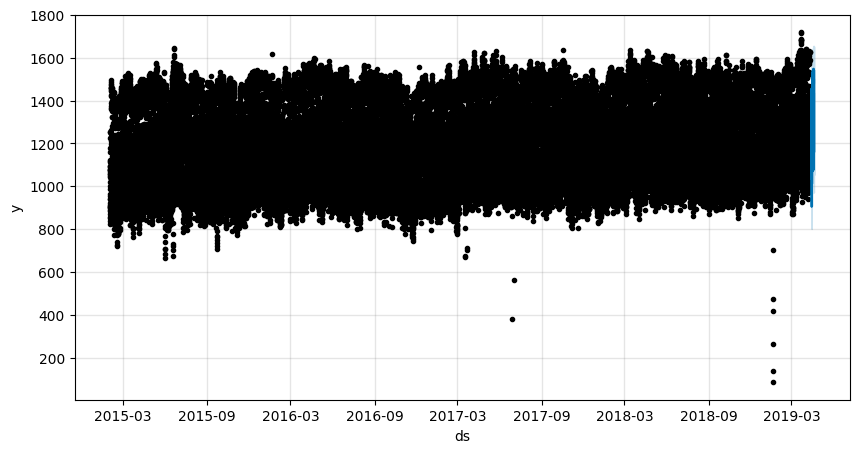

In [ ]:

fig, ax = plt.subplots(figsize = (10,5))
fig = model.plot(forcasted, ax = ax)
plt.show()

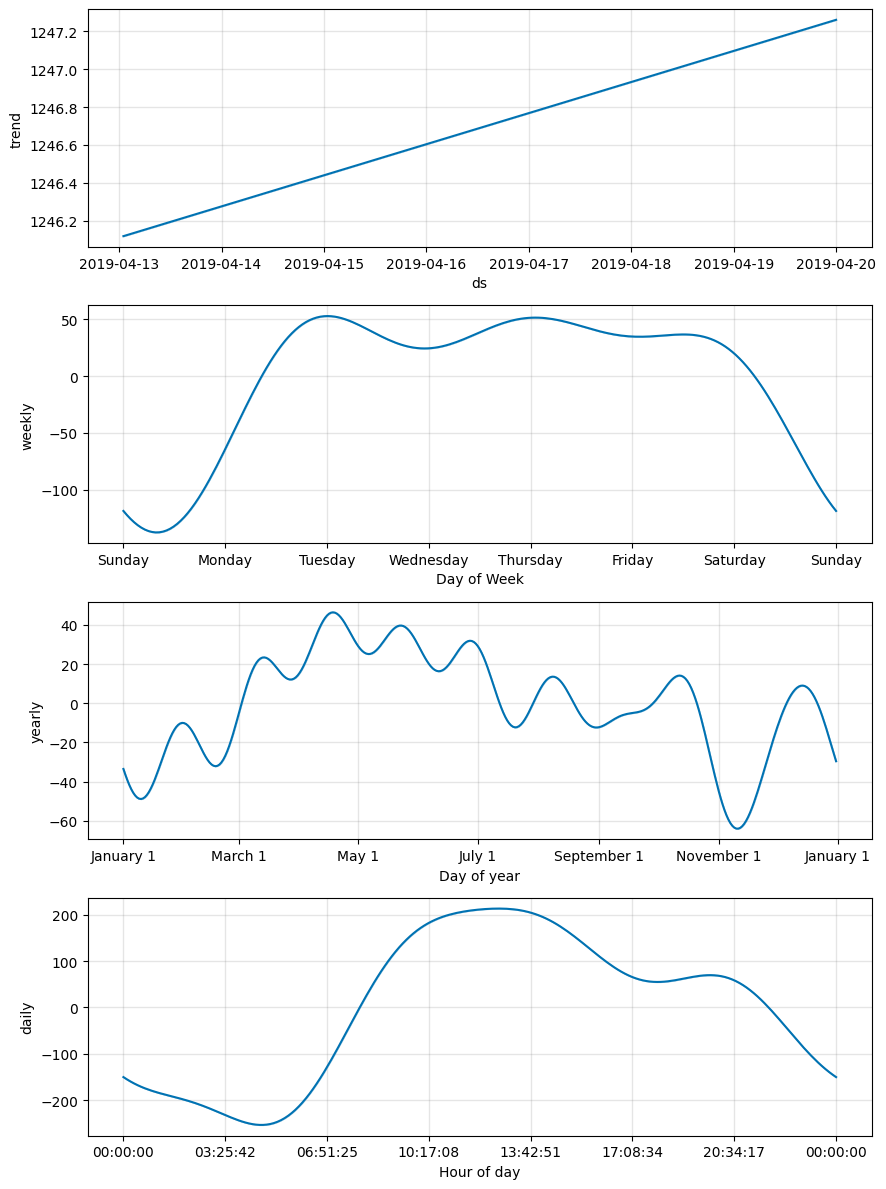

In [ ]:
fig = model.plot_components(forcasted)
plt.show()

### Comparing Forecasts to Actuals

We will now run some evaluation metrics to see how well the model actually did in comparing. We'll compare the forecasts to actuals by plotting the actual values alongside our model predicted values.



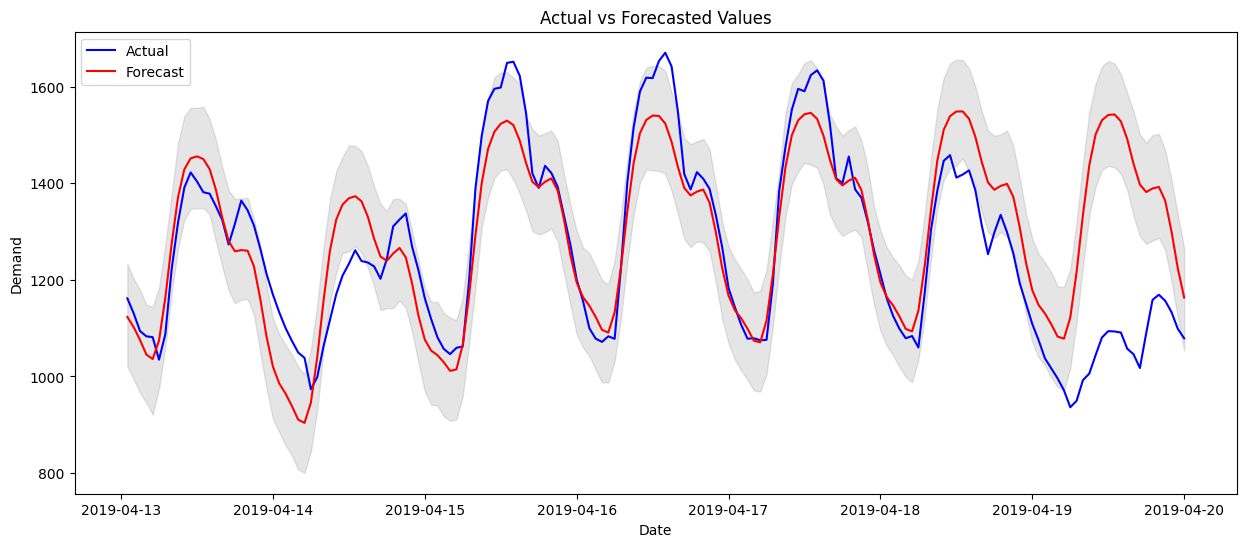

In [ ]:

plt.figure(figsize=(15, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='blue')
plt.plot(forcasted['ds'], forcasted['yhat'], label='Forecast', color='red')
plt.fill_between(forcasted['ds'], forcasted['yhat_lower'], forcasted['yhat_upper'], color='gray', alpha=0.2)
plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

### FB Prophet for a single train-test split


In [ ]:
mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])

print("Metrics for single train-test split:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)


mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])

print("Metrics for single train-test split with seasonality on:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)

## As we can see, there is no big difference with turning seasonality on and off. This is true for all datasets if you try it.
# Therefore, I will not incorporate it.

Metrics for single train-test split:
MAPE:  7.79
RMSE: 135.36932296513692
PLAPE: 7.2760612177456
VLAPE: 3.452462056279035
EAPE: 2.3938853931972837
Metrics for single train-test split with seasonality on:
MAPE:  7.87
RMSE: 135.046726407188
PLAPE: 7.296622882204859
VLAPE: 6.7798587472812155
EAPE: 1.3977813939660586


### Prophet model for entire dataset


In [ ]:
mape_simple = []
rmse_simple = []
plape_simple = []
vlape_simple = []
eape_simple = []

mape_seasonal = []
rmse_seasonal = []
plape_seasonal = []
vlape_seasonal = []
eape_seasonal = []



for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    train_simple = train[ "DEMAND"]
    test_simple = test[ "DEMAND"]
    train_prophet = train_simple.reset_index().rename(columns = {"datetime":"ds",
                                           "DEMAND":"y"})
    test_prophet = test_simple.reset_index().rename(columns = {"datetime":"ds",
                                           "DEMAND":"y"})
    model = Prophet()
    model.fit(train_prophet)
    forcasted = model.predict(test_prophet)
    mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])

    mape_simple.append(mape_score)
    rmse_simple.append(rmse_score)
    plape_simple.append(plape_score)
    vlape_simple.append(vlape_score)
    eape_simple.append(eape_score)


    model_seasonality = Prophet(seasonality_mode ="multiplicative")
    model_seasonality.fit(train_prophet)
    forcasted_seasonality = model_seasonality.predict(test_prophet)

    mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])

    mape_seasonal.append(mape_score)
    rmse_seasonal.append(rmse_score)
    plape_seasonal.append(plape_score)
    vlape_seasonal.append(vlape_score)
    eape_seasonal.append(eape_score)




metrics_df = pd.DataFrame({
    "MAPE": mape_simple,
    "RMSE": rmse_simple,
    "PLAPE": plape_simple,
    "VLAPE": vlape_simple,
    "EAPE": eape_simple
})

display(metrics_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/obypv6wr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/c_mks98f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62459', 'data', 'file=/tmp/tmpb5ozbe0o/obypv6wr.json', 'init=/tmp/tmpb5ozbe0o/c_mks98f.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_modelq1hhv8h4/prophet_model-20250228183152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/a4ggn9go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/e3x2697i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,MAPE,RMSE,PLAPE,VLAPE,EAPE
0,7.79,135.369323,7.276061,3.452462,2.393885
1,3.95,62.879901,4.085674,5.608331,0.537703
2,6.58,101.115777,11.093758,10.321322,5.650061
3,6.72,98.191125,6.185763,10.878466,0.659593
4,5.08,73.473525,7.051638,0.086861,0.211984
5,4.83,70.106846,4.535297,6.075822,2.155953
6,6.30,87.326126,0.665312,2.453999,4.828761
7,8.58,124.550216,13.206174,11.667066,1.467702
8,7.77,129.527011,2.550735,5.884826,4.842681
9,5.35,86.592452,6.643348,6.395875,1.442515


# FB Prophet - Holiday Effect incorporated

We need to make a holiday_df that incorporates all holidays. T We can just use the original dataset `continious.csv` to extract this data. This leads to drastic improvement in the model. However, the predictions are still better off without incorporating holiday effects as long as we don't turn on `seasonality_mode = yearly`. With that, the effects of holiday yield better accuracy

In [ ]:
file_path = "/content/drive/My Drive/Datasets/Panama_Dataset/continuous dataset.csv"
df = pd.read_csv(file_path)
df = df.set_index("datetime")
df.head()

holidays_df = df[df["holiday"] == 1]["Holiday_ID"]

holidays_df.head()


holidays_df = holidays_df.reset_index().rename(columns = {"datetime":'ds' , "Holiday_ID":"holiday"})

##using the metadata associated with the data to convert holiday id into the actual holiday names
holiday_mapping = {
    1: 'New Year',
    2: "Martyrs' Day",
    3: 'Carnival Saturday',
    4: 'Carnival Sunday',
    5: 'Carnival Monday',
    6: 'Carnival Tuesday',
    7: 'Ash Wednesday',
    8: 'Holy Thursday',
    9: 'Good Friday',
    10: 'Holy Saturday',
    11: 'Resurrection Sunday',
    12: 'Labor Day',
    13: 'Foundation of Old Panama',
    14: 'Separation of Panama from Colombia',
    15: 'Flag Day',
    16: 'Patriotic Commemoration in Colón city',
    17: 'First Cry of Independence',
    18: 'Independence of Panama from Spain',
    19: "Mother's Day",
    20: 'Christmas eve',
    21: 'Christmas',
    22: "New Year's Eve"
}


holidays_df['holiday'] = holidays_df['holiday'].map(holiday_mapping)
print(holidays_df.head())
print(len(holidays_df))

                    ds       holiday
0  2015-01-09 00:00:00  Martyrs' Day
1  2015-01-09 01:00:00  Martyrs' Day
2  2015-01-09 02:00:00  Martyrs' Day
3  2015-01-09 03:00:00  Martyrs' Day
4  2015-01-09 04:00:00  Martyrs' Day
3024


### FB Prophet Holiday Effect for Single Train-test

In [ ]:

holidays_prior_scale_value = 10

model_with_holiday = Prophet(holidays = holidays_df,holidays_prior_scale=holidays_prior_scale_value)
model_with_holiday.fit(train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/2fiqj4ez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/mpzmbtti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20714', 'data', 'file=/tmp/tmpb5ozbe0o/2fiqj4ez.json', 'init=/tmp/tmpb5ozbe0o/mpzmbtti.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_modelsx3qbbq3/prophet_model-20250228184459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forcasted_with_holiday = model_with_holiday.predict(test_prophet)

mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])

print("Metrics for single train-test split:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)

Metrics for single train-test split:
MAPE:  7.84
RMSE: 103.4874007596801
PLAPE: 2.346358320757003
VLAPE: 19.06766354386972
EAPE: 3.0616276839735534


### FB Prophet Holiday Effect for entire dataset

In [ ]:
mape_holiday = []
rmse_holiday = []
plape_holiday = []
vlape_holiday = []
eape_holiday = []

for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]

    train_holiday = train[ "DEMAND"]
    test_holiday = test[ "DEMAND"]

    train_holiday = train_holiday.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
    test_holiday = test_holiday.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
    model_with_holiday = Prophet(holidays = holidays_df)
    model_with_holiday.fit(train_holiday)
    forcasted_with_holiday = model.predict(test_holiday)

    mape_score_hol = mean_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    rmse_score_hol = root_mean_squared_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    plape_score_hol = peak_load_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    vlape_score_hol = value_load_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    eape_score_hol = energy_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])

    mape_holiday.append(mape_score_hol)
    rmse_holiday.append(rmse_score_hol)
    plape_holiday.append(plape_score_hol)
    vlape_holiday.append(vlape_score_hol)
    eape_holiday.append(eape_score_hol)




metrics_df = pd.DataFrame({
    "MAPE": mape_holiday,
    "RMSE": rmse_holiday,
    "PLAPE": plape_holiday,
    "VLAPE": vlape_holiday,
    "EAPE": eape_holiday
})

display(metrics_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/8ij_gtou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/r2zvsme4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63564', 'data', 'file=/tmp/tmpb5ozbe0o/8ij_gtou.json', 'init=/tmp/tmpb5ozbe0o/r2zvsme4.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_model71wrsvua/prophet_model-20250228184607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/jn0ojxha.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/oq5ny8pe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,MAPE,RMSE,PLAPE,VLAPE,EAPE
0,7.85,131.676069,9.558422,5.782023,0.017130
1,4.18,64.225093,4.164160,3.703719,1.138017
2,5.90,94.267262,11.081484,7.953732,4.851608
3,6.38,95.516417,7.419749,10.739146,0.132728
4,5.37,78.133314,8.869561,1.483334,1.880791
5,4.70,67.848930,5.436480,5.946911,1.591501
6,6.49,89.668640,0.987577,1.040398,5.118762
7,8.66,125.041324,10.273250,5.374157,2.909266
8,7.41,123.347087,3.630342,5.766710,4.166028
9,5.34,86.520736,6.784931,5.146228,1.809572


# FB Prophet with Temperature parameter added

We use a multiplicative effect since the impact of temperature is proportional to the temperature level. If the impact of a one-degree increase in temperature is larger when the overall temperature is high (or smaller when it's low), a multiplicative effect might be more appropriate. Multiplicative effects are common when dealing with percentages or proportional relationships. On the other hand, additive relation would be if temperature does nto have effect on electricity demand

In [ ]:
train = train[["T2M_toc","DEMAND"]]
test = test[["T2M_toc", "DEMAND"]]


train_prophet_temp = train.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y","T2M_toc":"T2M_toc" })
test_prophet_temp = test.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y","T2M_toc":"T2M_toc" })
test_prophet_temp.head()

,ds,T2M_toc,y
0,2020-06-13 01:00:00,25.864984,1010.6531
1,2020-06-13 02:00:00,25.748865,976.2663
2,2020-06-13 03:00:00,25.689111,947.0559
3,2020-06-13 04:00:00,25.674066,930.6396
4,2020-06-13 05:00:00,25.665491,922.1306


In [ ]:
model_with_temp = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)
model_with_temp.add_regressor('T2M_toc',mode='multiplicative')
#prior scale performs regularization to ensure overfitting does not occur
model_with_temp.fit(train_prophet_temp)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/k10rap9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/040qlaks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90090', 'data', 'file=/tmp/tmpb5ozbe0o/k10rap9_.json', 'init=/tmp/tmpb5ozbe0o/040qlaks.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_model8b9r4qz0/prophet_model-20250228185719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:57:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### FB Prophet with Temperature Effect for Single Test-train split

In [ ]:
forcasted_with_temp = model_with_temp.predict(test_prophet_temp)


mape_score = mean_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])

print("Metrics for single train-test split:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)

Metrics for single train-test split:
MAPE:  7.18
RMSE: 95.76467008777804
PLAPE: 5.338345892895559
VLAPE: 15.918331688327065
EAPE: 4.549073677548425


### FB Prophet with Temperature Effect for entire dataset

In [ ]:
mape_temp = []
rmse_temp = []
plape_temp = []
vlape_temp = []
eape_temp = []

for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]

    train = train[["T2M_toc","DEMAND"]]
    test = test[["T2M_toc", "DEMAND"]]

    train_holiday = train[ "DEMAND"]
    test_holiday = test[ "DEMAND"]

    train_prophet_temp = train.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y","T2M_toc":"T2M_toc" })
    test_prophet_temp = test.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y","T2M_toc":"T2M_toc" })


    model_with_temp = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)
    model_with_temp.add_regressor('T2M_toc',mode='additive')
    model_with_temp.fit(train_prophet_temp)

    forcasted_with_temp = model_with_temp.predict(test_prophet_temp)


    mape_score = mean_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
    rmse_score = root_mean_squared_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
    plape_score = peak_load_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
    vlape_score = value_load_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
    eape_score = energy_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])


    mape_temp.append(mape_score)
    rmse_temp.append(rmse_score)
    plape_temp.append(plape_score)
    vlape_temp.append(vlape_score)
    eape_temp.append(eape_score)



metrics_df = pd.DataFrame({
    "MAPE": mape_temp,
    "RMSE": rmse_temp,
    "PLAPE": plape_temp,
    "VLAPE": eape_temp,
})

display(metrics_df)



DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/ro39a05v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/5drexi1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20238', 'data', 'file=/tmp/tmpb5ozbe0o/ro39a05v.json', 'init=/tmp/tmpb5ozbe0o/5drexi1g.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_modeltkyi4qyw/prophet_model-20250228185848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/jcrcadjn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/qaiq5okb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,MAPE,RMSE,PLAPE,VLAPE
0,6.16,93.291392,5.404239,1.877865
1,4.00,64.630161,5.413021,1.369644
2,6.36,97.995342,10.887614,5.545320
3,6.15,92.591912,7.061257,0.164143
4,4.61,67.231096,5.912821,0.173819
5,4.26,63.242322,3.984416,1.263470
6,6.54,88.113850,0.501426,5.108003
7,7.37,103.806728,9.336897,1.979508
8,8.56,122.729280,3.449737,6.888709
9,5.68,89.269434,1.750120,3.191006


# FB Prophet (Entire Dataset)

In [ ]:

train_all = train[["dayOfWeek","weekend","hourOfDay","T2M_toc","DEMAND"]]
test_all = test[["dayOfWeek","weekend","hourOfDay","T2M_toc","DEMAND"]]

train_prophet_all = train_all.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
test_prophet_all = test_all.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
test_prophet_all.head()

,ds,dayOfWeek,weekend,hourOfDay,T2M_toc,y
0,2019-04-13 01:00:00,1,1,1,26.791528,1161.6177
1,2019-04-13 02:00:00,1,1,2,26.707971,1130.4635
2,2019-04-13 03:00:00,1,1,3,26.616541,1093.8777
3,2019-04-13 04:00:00,1,1,4,26.542291,1083.0332
4,2019-04-13 05:00:00,1,1,5,26.467188,1081.2705


### FB Prophet (Entire Dataset) for Single Test-train Split

In [ ]:
model_with_all = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)
model_with_all.add_regressor('T2M_toc',mode='multiplicative')
#prior scale performs regularization to ensure overfitting does not occur --> IMPLEMENT THIS LATER
#model3.add_regressor('PRCP',prior_scale=0.5,mode='multiplicative')
model_with_all.add_regressor('dayOfWeek',mode='multiplicative')
model_with_all.add_regressor('weekend',mode='multiplicative')
model_with_all.add_regressor('hourOfDay',mode='multiplicative')

model_with_all.fit(train_prophet_all)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/7bbcrou3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/4g_vbm_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99803', 'data', 'file=/tmp/tmpb5ozbe0o/7bbcrou3.json', 'init=/tmp/tmpb5ozbe0o/4g_vbm_s.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_modelp4q52ocp/prophet_model-20250228192118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forcasted_with_all = model_with_all.predict(test_prophet_all)

mape_score = mean_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])

print("Metrics for single train-test split:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)

Metrics for single train-test split:
MAPE:  6.22
RMSE: 94.75593298845573
PLAPE: 5.68576539231195
VLAPE: 16.449737121307066
EAPE: 2.311598646523717


### FB Prophet (Entire Dataset) for all splits

In [ ]:
mape_all = []
rmse_all = []
plape_all = []
vlape_all = []
eape_all = []





for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]

    train_all = train[["dayOfWeek","weekend","hourOfDay","T2M_toc","DEMAND"]]
    test_all = test[["dayOfWeek","weekend","hourOfDay","T2M_toc","DEMAND"]]

    train_prophet_all = train_all.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
    test_prophet_all = test_all.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})

    model_with_all = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)


    model_with_all.add_regressor('T2M_toc',mode='multiplicative')
    model_with_all.add_regressor('dayOfWeek',mode='multiplicative')
    model_with_all.add_regressor('weekend',mode='multiplicative')
    model_with_all.add_regressor('hourOfDay',mode='multiplicative')
    model_with_all.fit(train_prophet_all)



    forcasted_with_all = model_with_all.predict(test_prophet_all)


    mape_score = mean_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
    rmse_score = root_mean_squared_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
    plape_score = peak_load_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
    vlape_score = value_load_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
    eape_score = energy_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])


    mape_all.append(mape_score)
    rmse_all.append(rmse_score)
    plape_all.append(plape_score)
    vlape_all.append(vlape_score)
    eape_all.append(eape_score)



metrics_df = pd.DataFrame({
    "MAPE": mape_all,
    "RMSE": rmse_all,
    "PLAPE": plape_all,
    "VLAPE": eape_all,
})

display(metrics_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/egrp7zrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/cw7tjg9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25457', 'data', 'file=/tmp/tmpb5ozbe0o/egrp7zrb.json', 'init=/tmp/tmpb5ozbe0o/cw7tjg9j.json', 'output', 'file=/tmp/tmpb5ozbe0o/prophet_modelll33bc5q/prophet_model-20250228192202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:22:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/aspjbazi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb5ozbe0o/3rlbyf79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,MAPE,RMSE,PLAPE,VLAPE
0,6.22,94.755933,5.685765,2.311599
1,4.03,65.708837,5.960413,2.019141
2,6.45,98.824113,10.881086,5.725952
3,5.88,91.927990,6.855578,0.134448
4,4.23,65.125815,5.796538,0.361093
5,4.08,60.913418,3.853211,1.147399
6,6.40,86.694922,0.647504,5.126981
7,7.22,104.885148,8.853674,1.660204
8,8.96,127.932296,4.414700,7.419993
9,6.01,91.888409,0.923308,3.519780


In [ ]:

weeks = ["Week 15 Apr 2019", "Week 21 May 2019", "Week 24 Jun 2019", "Week 29 Jul 2019", "Week 33 Aug 2019", "Week 37 Sep 2019",
         "Week 41 Oct 2019", "Week 44 Nov 2019", "Week 51 Dec 2019", "Week 01 Jan 2020", "Week 06 Feb 2020",
         "Week 10 Mar 2020", "Week 20 May 2020", "Week 24 Jun 2020"]

data_prophet = {
    "Weeks": weeks,
    "MAPE": mape_all,
    "RMSE": rmse_all,
    "PLAPE": plape_all,
    "VLAPE": vlape_all,
    "EAPE": eape_all,
}

df_prophet = pd.DataFrame(data_prophet)

df_prophet.set_index("Weeks", inplace=True)
display(df_prophet)


,MAPE,RMSE,PLAPE,VLAPE,EAPE
Weeks,,,,,
Week 15 Apr 2019,6.22,94.755933,5.685765,16.449737,2.311599
Week 21 May 2019,4.03,65.708837,5.960413,8.716707,2.019141
Week 24 Jun 2019,6.45,98.824113,10.881086,11.760900,5.725952
Week 29 Jul 2019,5.88,91.927990,6.855578,12.162369,0.134448
Week 33 Aug 2019,4.23,65.125815,5.796538,2.984814,0.361093
Week 37 Sep 2019,4.08,60.913418,3.853211,7.366939,1.147399
Week 41 Oct 2019,6.40,86.694922,0.647504,2.787059,5.126981
Week 44 Nov 2019,7.22,104.885148,8.853674,24.744422,1.660204
Week 51 Dec 2019,8.96,127.932296,4.414700,5.336180,7.419993


The FBprophet model outperforms AR, MA and ARMA model. However, it fell slightly short of ARIMA and ARIMAX performance.

To note is that we were modelling only a week into the future. Had we been predicting farther ahead (a month or two), the errors from autoregressed variables would have severely effected the accuracy of models such as ARIMA and ARIMAX.